# Preprocessing and cluster annotation

***

Jan T. Schleicher, 2023

In this notebook, we perform quality control and preprocess the raw count data. Then, we perform clustering and create cell type annotations based on marker gene expression. We also compute RNA velocities.

In [1]:
# Import required packages
import os

import numpy as np
import pandas as pd

import scvelo as scv
import scanpy as sc

from scipy import sparse

import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib

np.random.seed(42)

%config Completer.use_jedi = False

In [2]:
DATA_PATH = "../data/"
OUTPUT_PATH = "../output/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
# Import raw AnnData
adata = sc.read(os.path.join(DATA_PATH, "tex_data_chronic.h5ad"))
adata

AnnData object with n_obs × n_vars = 13763 × 27998
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Quality control

We check basic gene and cell QC measures and filter the AnnData object based on their values.

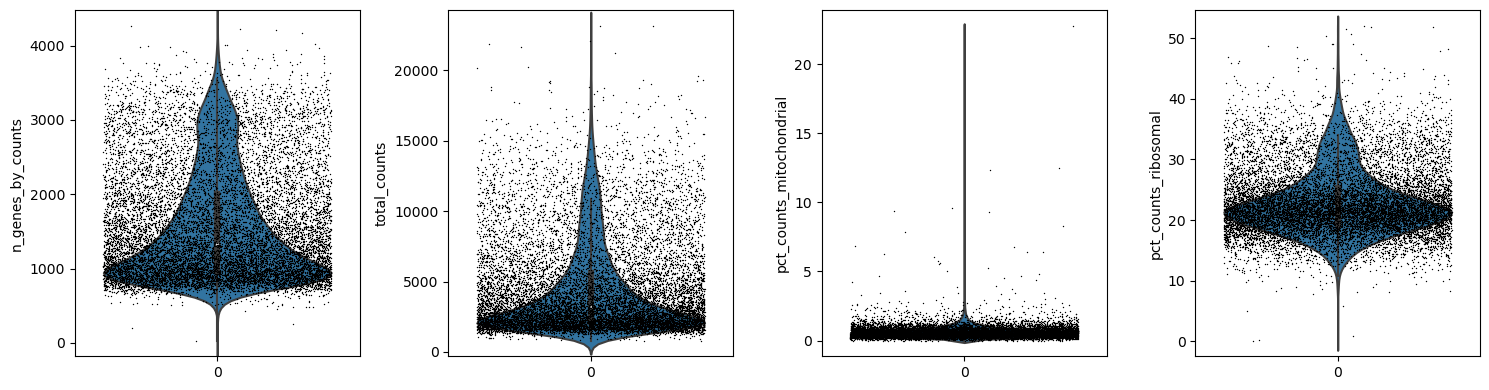

In [4]:
# Check QC measures
adata.var["mitochondrial"] = adata.var_names.str.startswith("mt-")
adata.var["ribosomal"] = adata.var_names.str.startswith(("Rps", "Rpl"))
qc_df = sc.pp.calculate_qc_metrics(adata, qc_vars=["mitochondrial","ribosomal"],
                                   percent_top=[20], log1p=True, inplace=True)

# Cell QC measures
fig, axs = plt.subplots(ncols=4, figsize=(15,4))

for i, qc_ in enumerate(["n_genes_by_counts", "total_counts", 
                      "pct_counts_mitochondrial",
                      "pct_counts_ribosomal",
                      ]):
    sns.violinplot(adata.obs[qc_], ax=axs.flat[i])
    sns.stripplot(adata.obs[qc_], jitter=0.4, s=1, 
                  color="black", ax=axs.flat[i])
plt.tight_layout()

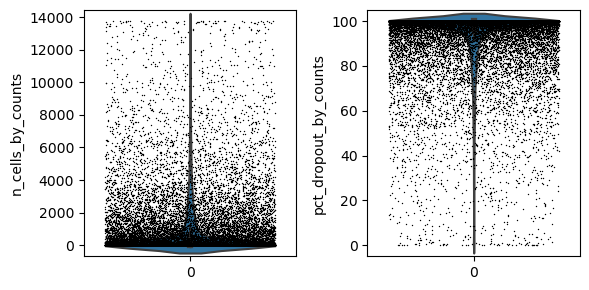

In [5]:
# Gene QC measures
fig, axs = plt.subplots(ncols=2, figsize=(6,3))

for i, qc_ in enumerate(["n_cells_by_counts", "pct_dropout_by_counts", 
                      ]):
    sns.violinplot(adata.var[qc_], ax=axs.flat[i])
    sns.stripplot(adata.var[qc_], jitter=0.4, s=1, 
                  color="black", ax=axs.flat[i])
    
plt.tight_layout()

In [6]:
# Filter based on QC
scv.pp.filter_genes(adata, min_shared_counts=20)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, max_genes=3500)
sc.pp.filter_cells(adata, max_counts=15000)

# Filter based on mitochondrial and ribosomal
adata = adata[adata.obs.pct_counts_mitochondrial <= 2]
adata = adata[adata.obs.pct_counts_ribosomal >= 10]
adata = adata[adata.obs.pct_counts_ribosomal <= 40]

adata

Filtered out 20743 genes that are detected 20 counts (shared).


View of AnnData object with n_obs × n_vars = 13410 × 7255
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

## Data (pre)processing

We score genes based on their expression of cell cycle genes, compute highly variable genes, normalize total counts, and remove mitochondrial and ribsosomal genes. Then, we perform gene-wise scaling and regress out the cell cycle score difference between S and G2M scores to remove cell cycle effects. Dimensionality reduction is performed with PCA and UMAP, and cells are clustered using the Leiden algorithm.

In [7]:
# Cell cycle scoring
cell_cycle_genes = [x.strip().capitalize() for x in open(os.path.join(DATA_PATH, "regev_lab_cell_cycle_genes.txt"))]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

adata_ = sc.pp.normalize_total(adata, copy=True)
sc.pp.log1p(adata_)
sc.pp.scale(adata_)

sc.tl.score_genes_cell_cycle(adata_, s_genes=s_genes, g2m_genes=g2m_genes)

adata.obs["phase"] = adata_.obs.phase
adata.obs["S_score"] = adata_.obs.S_score
adata.obs["G2M_score"] = adata_.obs.G2M_score
adata.obs["score_diff"] = adata.obs.S_score - adata.obs.G2M_score

adata.var["cell_cycle_genes"] = False
adata.var.loc[[gene for gene in cell_cycle_genes if gene in adata.var_names], "cell_cycle_genes"] = True

In [8]:
# Preprocess the dataset
adata.layers["counts"] = adata.X.copy()

# scVelo selection
scv.pp.filter_and_normalize(adata, flavor="cell_ranger", log=True, n_top_genes=5000, subset_highly_variable=False)

# Remove mitochondrial and ribosomal genes
keep_genes = np.intersect1d(adata.var.index[~adata.var.mitochondrial], 
                           adata.var.index[~adata.var.ribosomal])
adata = adata[:, keep_genes]
adata

Normalized count data: X, spliced, unspliced.
Extracted 5000 highly variable genes.
Logarithmized X.


View of AnnData object with n_obs × n_vars = 13410 × 7170
    obs: 'sampleID', 'barcode', 'sample_type', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mitochondrial', 'log1p_total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_genes', 'n_counts', 'phase', 'S_score', 'G2M_score', 'score_diff'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'mitochondrial', 'ribosomal', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'cell_cycle_genes', 'gene_count_corr', 'means', 'dispersions', 'dispersions_norm', 'highly_variable'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced', 'counts'

In [9]:
# Dimensionality reduction and clustering
adata.layers["log1p"] = adata.X.copy()
sc.pp.scale(adata)
adata.layers["scaled"] = adata.X.copy()
sc.pp.regress_out(adata, ["score_diff"])
sc.pp.scale(adata)

sc.pp.pca(adata, use_highly_variable=True)
sc.pp.neighbors(adata, use_rep="X_pca", n_neighbors=30, random_state=0)
sc.tl.leiden(adata, random_state=0)
sc.tl.umap(adata, random_state=0)
adata.obsm["X_umap"][:, 1] = -adata.obsm["X_umap"][:, 1]

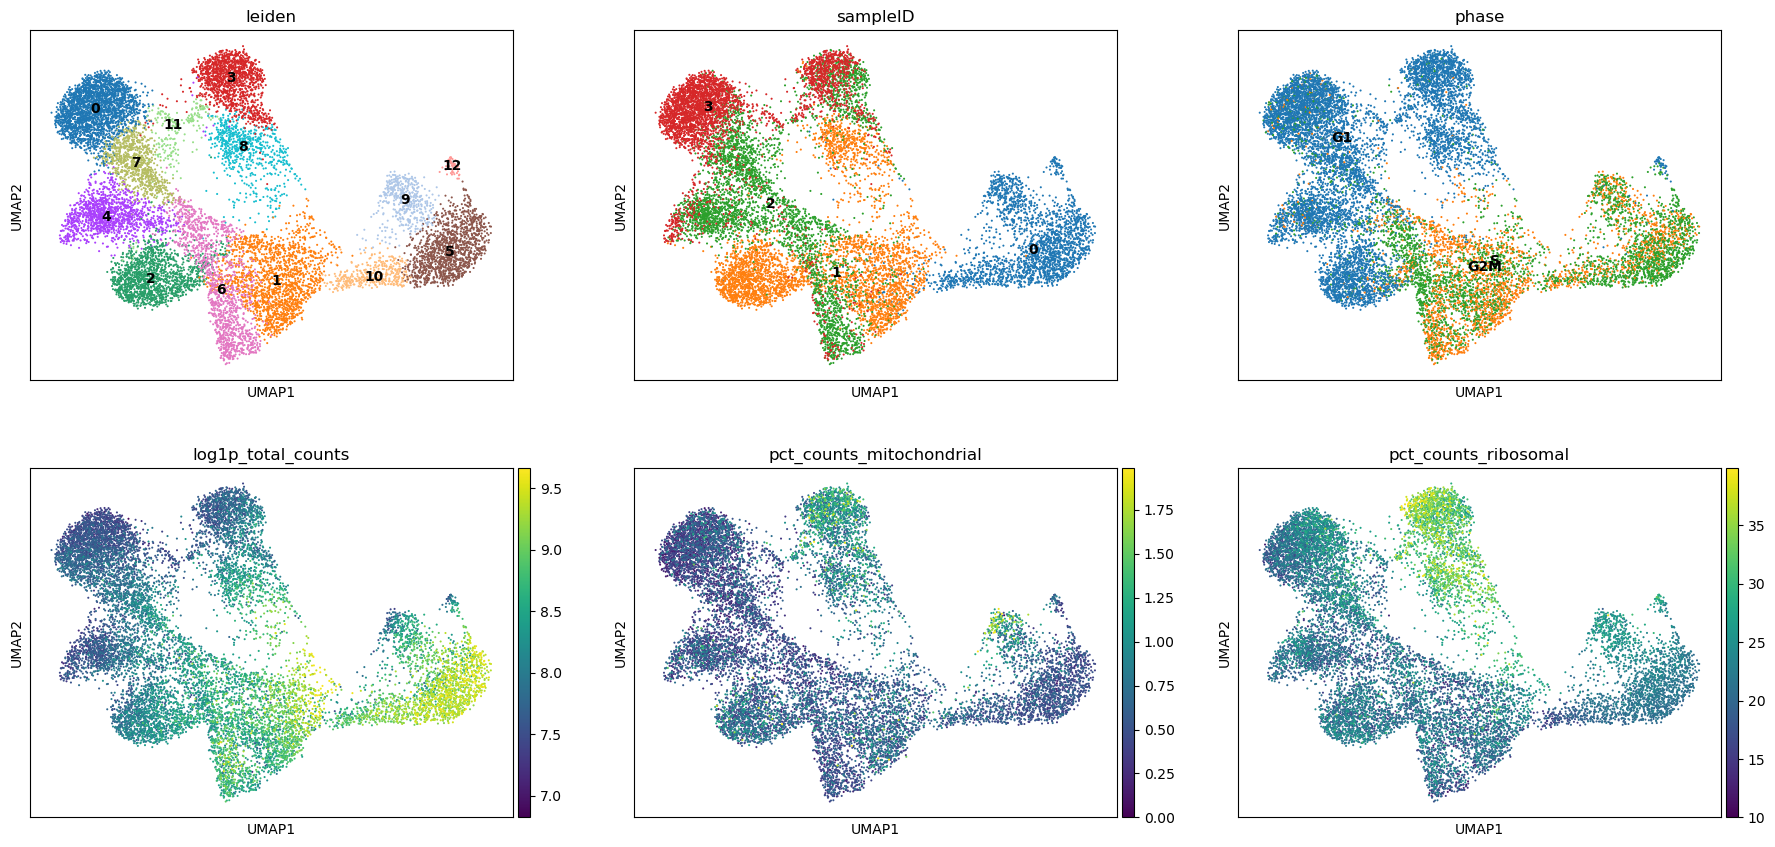

In [10]:
sc.pl.umap(adata, color=["leiden", "sampleID", "phase",
                         "log1p_total_counts", "pct_counts_mitochondrial", "pct_counts_ribosomal"],
           legend_loc="on data", ncols=3, cmap="viridis")

## RNA velocity analysis

RNA velocities are computed with the stochastic model from `scvelo`.

In [11]:
# Velocity analysis

# Smooth over k neighbors
scv.pp.moments(adata)

# Compute gene dynamics (optional)
scv.tl.recover_dynamics(adata, n_jobs=-1)

# Estimate velocity
scv.tl.velocity(adata, mode="stochastic")

# Post velocity analysis
scv.tl.velocity_graph(adata, mode_neighbors="connectivities", n_jobs=-1)
scv.tl.terminal_states(adata)
scv.tl.latent_time(adata)
scv.tl.velocity_confidence(adata)

# Transition probability matrix
adata.uns["T_forward"] = scv.utils.get_transition_matrix(adata, self_transitions=False)

# Visualize velocity
scv.tl.velocity_embedding(adata)

computing moments based on connectivities
    finished (0:00:07) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics (using 52/52 cores)


/home/ubuntu/miniconda3/envs/cytopath/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/1469 [00:00<?, ?gene/s]

    finished (0:39:59) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:10) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 52/52 cores)


/home/ubuntu/miniconda3/envs/cytopath/lib/python3.8/site-packages/ipywidgets/widgets/widget.py:438: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


  0%|          | 0/13410 [00:00<?, ?cells/s]

Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


    finished (0:00:48) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:09) --> added 
    'latent_time', shared time (adata.obs)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


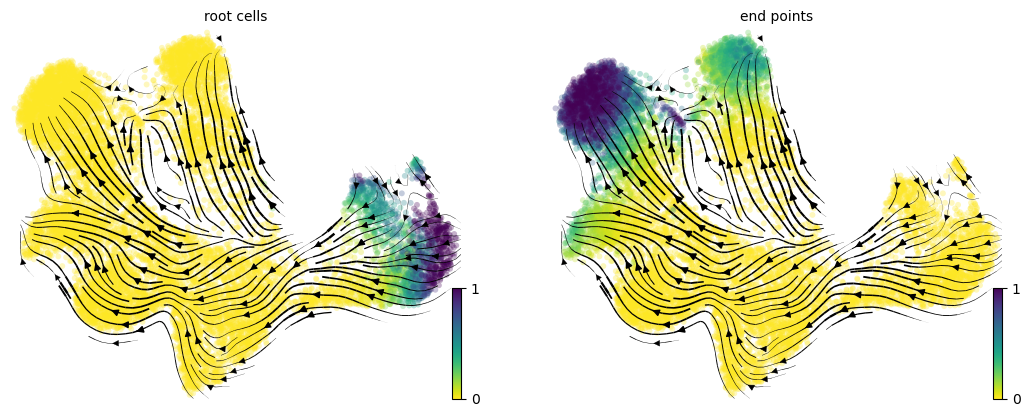

In [12]:
scv.pl.velocity_embedding_stream(adata, color=["root_cells", "end_points"])

## Cell type annotation

Genes that are differentially expressed between Leiden clusters are compared to known markers for exhausted T cell subpopulations. Additionally, mean expression of these marker genes per Leiden cluster is used to merge and annotate clusters.

In [13]:
# Differentially expressed genes per cluster
sc.tl.rank_genes_groups(adata, groupby="leiden", method="wilcoxon")

# Known marker genes of exhausted T cell subpopulations
marker_genes_dict = {"term_exh": ["Cxcr6", "Cd160", "Eomes", "Tox", "Lag3", "Entpd1"],
                     "mem_like": ["Il7r", "Tcf7", "Slamf6"],
                     "prolif": ["Mki67", "Cdca8"],
                     "exh": ["Gzmb", "Bcl2l11", "Anxa1", "Pdcd1"],
                     "eff_like": ["Cx3cr1", "Klre1", "Klra3", "Klrg1"],
                     "early": ["Icos", "Cdk2", "Sell"]}

marker_gene_overlap_tex = sc.tl.marker_gene_overlap(adata, marker_genes_dict, normalize="reference")

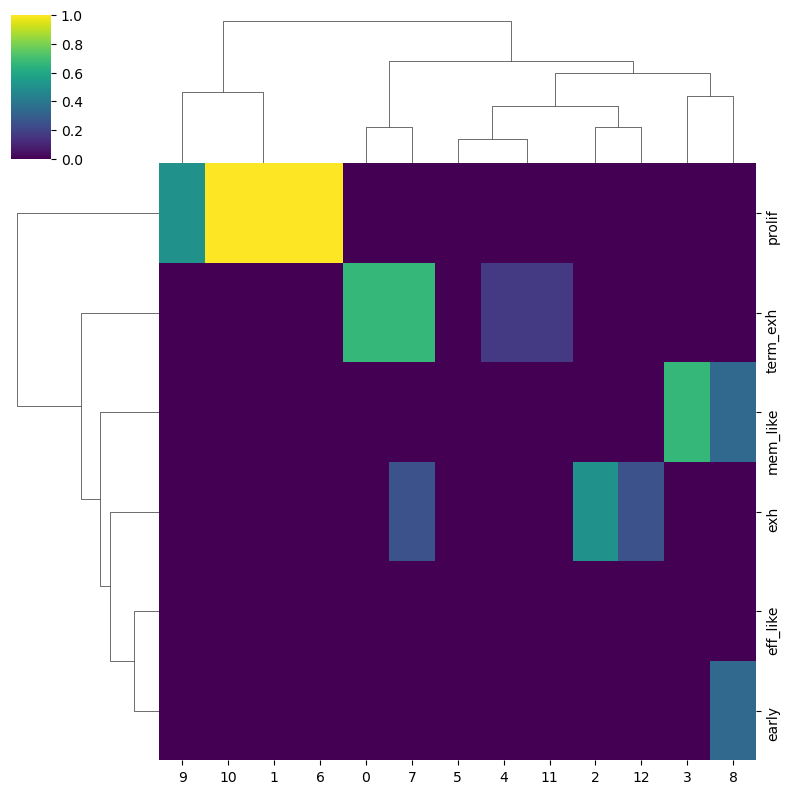

In [14]:
sns.clustermap(marker_gene_overlap_tex, cmap="viridis", figsize=(8, 8))

In [15]:
# Mean expression of marker genes per cluster
marker_genes = [m for l in marker_genes_dict.values() for m in l]
mean_exp = pd.DataFrame(columns=marker_genes, index=adata.obs.leiden.cat.categories, dtype=float)
for clust in adata.obs.leiden.cat.categories:
    mean_exp.loc[clust] = adata[adata.obs.leiden == clust, marker_genes].X.mean(axis=0)
mean_exp

,Cxcr6,Cd160,Eomes,Tox,Lag3,Entpd1,Il7r,Tcf7,Slamf6,Mki67,...,Bcl2l11,Anxa1,Pdcd1,Cx3cr1,Klre1,Klra3,Klrg1,Icos,Cdk2,Sell
0,0.811168,0.497505,0.221554,0.499866,0.391567,0.216022,-0.231322,-0.216451,-0.437402,-0.485475,...,0.043880,-0.220135,0.122766,-0.171123,-0.098747,-0.061487,-0.077508,-0.349743,-0.295336,-0.121482
1,-0.127820,-0.261505,-0.288828,-0.431191,-0.201095,-0.082098,-0.180789,-0.129539,0.003117,0.918269,...,-0.067157,0.413158,0.038957,-0.078872,-0.066146,-0.100694,0.038779,0.096987,0.401426,-0.017354
2,0.353884,-0.178875,-0.311944,-0.273301,0.243724,-0.039651,-0.058069,-0.192383,0.033819,-0.402395,...,0.550451,0.583015,0.059607,0.000115,-0.056485,-0.024731,0.073053,0.190124,-0.206728,-0.109288
3,-0.804870,-0.341359,0.246591,0.243772,0.086403,-0.158830,1.239157,0.891727,0.949279,-0.537568,...,-0.141635,-0.156946,-0.349673,-0.154560,-0.054479,-0.163248,-0.076073,0.375674,-0.323849,0.259364
4,0.225042,-0.583014,0.077167,0.237015,-0.007848,0.036596,-0.221233,-0.135357,-0.325664,-0.462139,...,-0.040865,-0.012441,-0.240934,0.914845,0.590741,0.462808,0.258751,-0.447275,-0.228953,-0.052033
5,-0.946391,-0.184344,-0.345415,-0.774232,-0.938752,-0.167589,-0.143688,-0.074694,-0.054028,0.581325,...,-0.361270,-0.170454,-0.090765,-0.146838,-0.109087,-0.155540,-0.071504,0.447143,0.535614,-0.112990
6,0.139202,0.383533,0.367448,0.317961,0.055815,0.079630,-0.253744,-0.202296,-0.354240,0.774271,...,-0.030428,-0.204342,0.186334,0.060897,0.035920,0.233514,0.012952,-0.455542,0.364864,-0.117606
7,0.988972,0.675676,0.206723,0.516174,0.712844,0.206289,-0.234165,-0.219287,-0.360500,-0.425523,...,0.137618,-0.192360,0.627650,-0.072666,0.007769,0.177746,-0.070344,-0.252636,-0.221895,-0.118851
8,-0.880816,0.228538,-0.032655,-0.028738,0.128586,-0.171741,0.417148,0.858635,1.359692,-0.417478,...,0.226982,-0.113519,-0.003589,-0.176624,-0.128174,-0.162311,-0.081447,0.665723,-0.216982,0.915789
9,-0.971630,-0.181931,-0.393476,-0.769529,-1.008717,-0.170135,-0.112478,-0.029468,-0.052396,0.602289,...,-0.397311,-0.168136,-0.428426,-0.138507,-0.137843,-0.168255,-0.084578,0.451382,0.211826,-0.099754


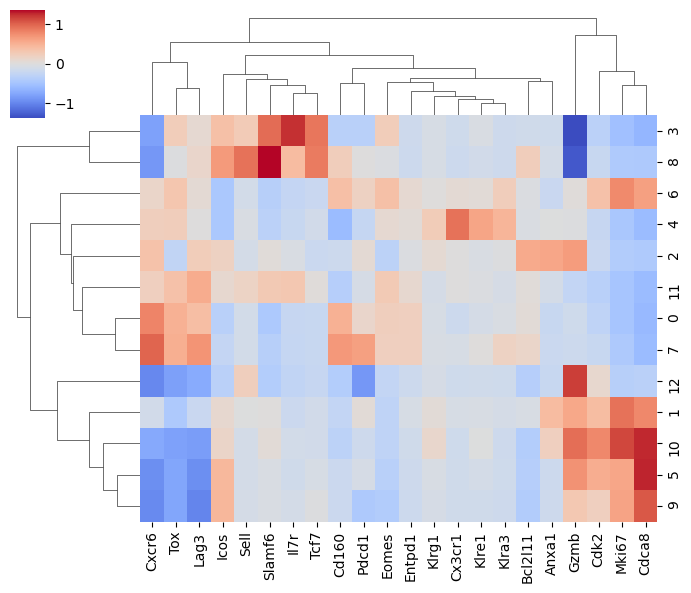

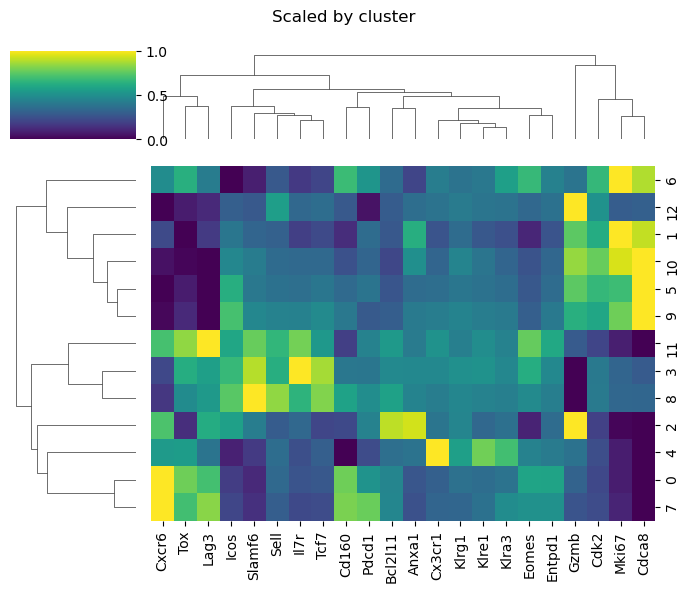

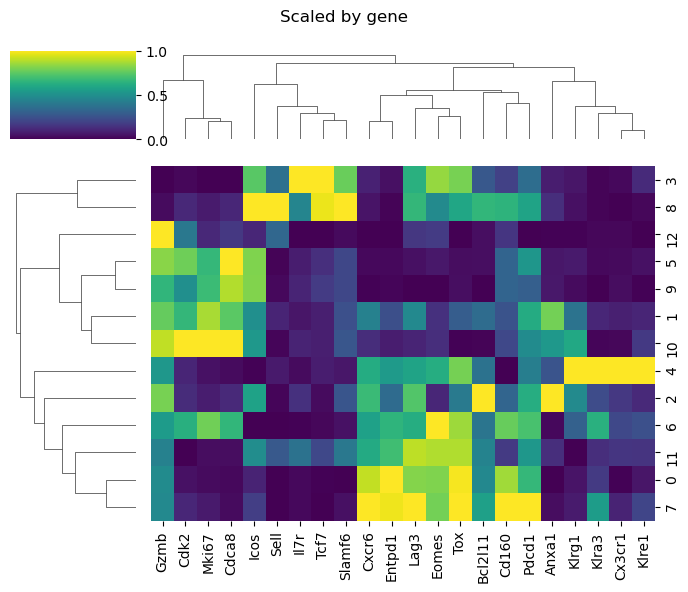

In [16]:
sns.clustermap(mean_exp, cmap="coolwarm", figsize=(7, 6))
sns.clustermap(mean_exp, cmap="viridis", figsize=(7, 6), standard_scale=0).fig.suptitle("Scaled by cluster")
plt.tight_layout()
sns.clustermap(mean_exp, cmap="viridis", figsize=(7, 6), standard_scale=1).fig.suptitle("Scaled by gene")
plt.tight_layout()

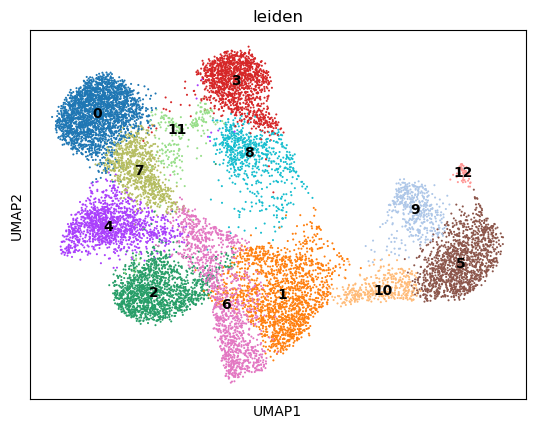

In [17]:
sc.pl.umap(adata, color="leiden", legend_loc="on data")

In [18]:
# Merge and annotate clusters based on mean marker expression
adata.obs["annot"] = pd.Series(dtype=str)
adata.obs.annot[adata.obs.leiden.isin(["3", "8"])] = "mem_like"  # Tcf7, Slamf6, Il7r
adata.obs.annot[adata.obs.leiden == "4"] = "eff_like"  # Klra3, Klrg1, Cx3cr1, Klre1
adata.obs.annot[adata.obs.leiden.isin(["0", "7", "11"])] = "term_exh"  # Cxcr6, Entpd1, Lag3, Eomes, Tox
adata.obs.annot[adata.obs.leiden.isin(["1", "6"])] = "prolif"  # Mki67, Cdca3, Cdca8
adata.obs.annot[adata.obs.leiden == "2"] = "int_exh"  # Anxa1, Bcl2l11, Gzmb
adata.obs.annot[adata.obs.leiden.isin(["5", "9", "10", "12"])] = "early"  # Icos, Cdk2
adata.obs.annot = adata.obs.annot.astype("category")

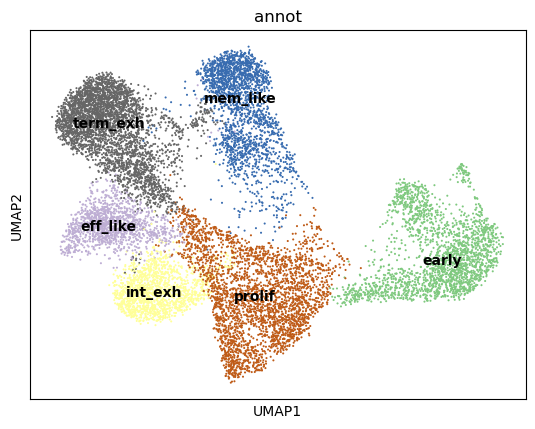

In [19]:
sc.pl.umap(adata, color="annot", legend_loc="on data", palette="Accent")

In [20]:
# Identify differentially expressed genes between merged clusters
sc.tl.rank_genes_groups(adata, groupby="annot", method="wilcoxon", key_added="rank_genes_groups_annot")

In [21]:
adata.write_h5ad(os.path.join(DATA_PATH, "tex_data_chronic_annotated.h5ad"))

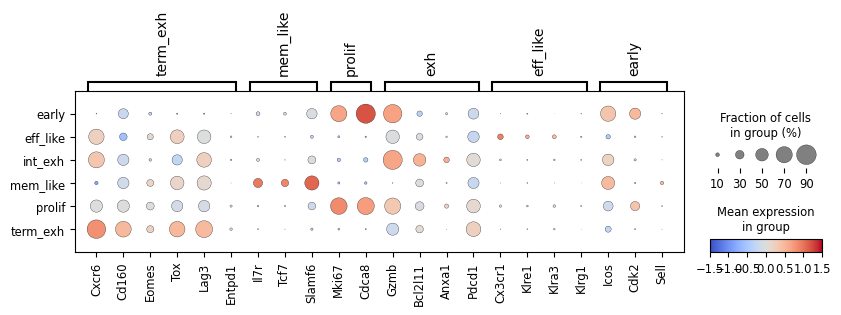

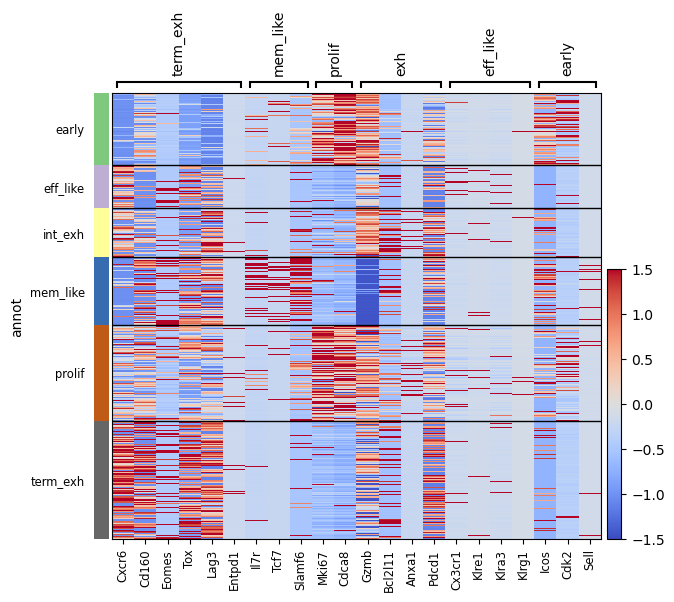

In [22]:
# Plot markers by annotated clusters
sc.pl.dotplot(adata, var_names=marker_genes_dict, groupby="annot", cmap="coolwarm", vmin=-1.5, vcenter=0, vmax=1.5)
sc.pl.heatmap(adata, var_names=marker_genes_dict, groupby="annot", cmap="coolwarm", vmin=-1.5, vcenter=0, vmax=1.5)